In [1]:
""" windtower_pdf.ipynb 
    
    Get a distribution of wind speeds for a given time period using weather station data.
    Used as a preprocessing and data wrangling step for the WEMO model calibration.
    NOTE: Neat 1, 2, and 3 use the same wind data. I compute them separately for the sake of keeping my code consistent 
    
    Weather station information: 
        - Pullman: MWH, Moses Lake/Grant County
        - Moab: CNY, Moab/Canyonlands
        - Holloman: HMN, Holloman AFB
        - Mandan: Y19, Mandam
        - San Luis Valley: ALS, Alamosa Municipal County Airport
        - NEAT 1, 2, &3: Las Cruces, New Mexico

    Author: Nicole Keeney 
    Date Created: 02/02/2022
    Modification History: 
        - Fixed dates for NEAT sites to include first measurment date from sediment weights (02-08-2022)

"""
import os
import sys 
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

sys.path.append('..')
from utils.read_data_utils import read_datetime_csv, read_windtower_data

In [2]:
def calculate_pdf(data, bins): 
    """ Calculate probability density function 
    Will return dataframe without the first bin; i.e. assigns values between 0-0.2 to bin 0.2

    Args: 
        data (pd.Series): data to compute PDF for 
        bins (list): bins to use for PDF 

    Returns: 
        pdf_df (pd.DataFrame): PDF with bins as index 

    """
    groups = data.groupby(pd.cut(data, bins)) # Group data by bins. Computes count in each bin 
    pdf_df = pd.DataFrame(groups.count()/sum(groups.count())) # Compute frequency in each bin 
    pdf_df["bins"] = bins[:-1] # Add bins as column
    pdf_df = pdf_df.reset_index(drop=True).set_index("bins") # Drop default index; set bins to index 
    pdf_df.rename(columns={pdf_df.columns[0]:"frequency"}, inplace=True) # Rename column to frequency
    return pdf_df 

In [3]:
# --------------- USER INPUTS ---------------

# List of sites to compute wind PDF for 
# If you just want to compute it for one site, make sure it's in a list; i.e. ["NEAT1"]
site_list = ["Moab","Pullman","Holloman","Mandan","SanLuisValley","NEAT1","NEAT2","NEAT3"]

# Directory containing wind and flux data for each site 
data_dir = "../data/site_data/"

# Wind bins to use for computing PDF 
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,1000]

Computing wind PDF for Moab... complete


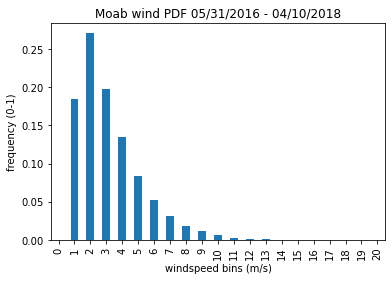

Computing wind PDF for Pullman... complete


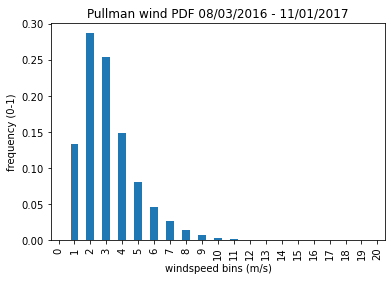

Computing wind PDF for Holloman... complete


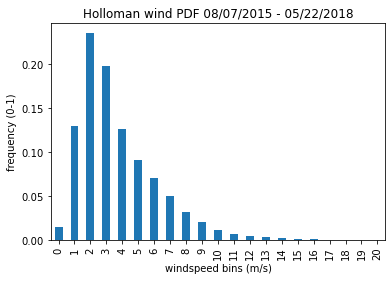

Computing wind PDF for Mandan... complete


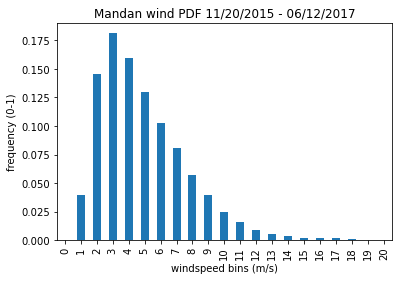

Computing wind PDF for SanLuisValley... complete


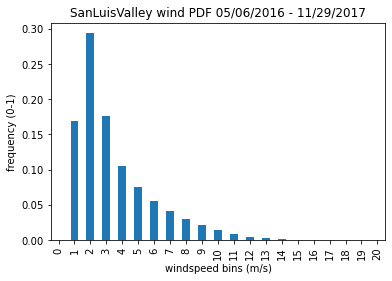

Computing wind PDF for NEAT1... complete


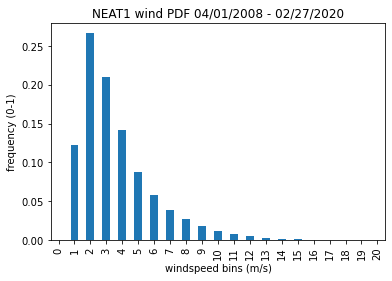

Computing wind PDF for NEAT2... complete


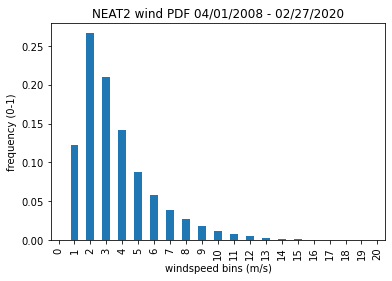

Computing wind PDF for NEAT3... complete


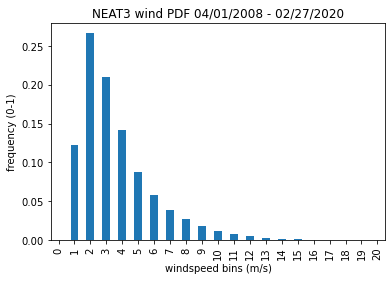

In [4]:
# --------------- COMPUTE WIND PDF ---------------

# Loop through each site and compute wind pdf
for site_name in site_list: 
    
    print("Computing wind PDF for "+site_name+"...", end=" ")
    
    # Read in data for that site
    wind_data = read_windtower_data(data_dir=data_dir, site_name=site_name) # Wind tower measurment data
    flux_data = read_datetime_csv(path = data_dir+site_name+"/field_Q/"+site_name+"_fieldQ.csv") # Sediment flux measurements
    measurement_dates = list(flux_data.index) # Measurement dates 
    
    if "NEAT" in site_name: 
        first_date = pd.to_datetime("2008-04-01") # Date lost during computation of Q from sediment weights 
        measurement_dates = [first_date] + measurement_dates
    
    # Loop through each measurement date, excluding the final date 
    wind_pdf_all = [] # Append PDF for each date here 
    for i in range(len(measurement_dates)-1): 

        # Get range of dates that occur around 
        start_date = measurement_dates[i] 
        end_date = measurement_dates[i+1]

        # Get wind measurements that occur within the date meriod 
        # Add 1 day to end date since using <= will miss the last full day of measurements 
        mask = (wind_data.index > start_date) & (wind_data.index <= end_date + timedelta(days=1))
        wind_masked = wind_data.loc[mask]
        
        # Compute PDF 
        wind_pdf_i = calculate_pdf(data=wind_masked, bins=bins)
        
        # Append to list 
        wind_pdf_all.append(wind_pdf_i.frequency)
    
    # Combine to form one dataframe 
    pdf_df = pd.DataFrame(data=wind_pdf_all, index=measurement_dates[1:]) # Skip first day
    pdf_df.index.name = "Date"
    
    # Save csv 
    output_filename = site_name + "_wind_pdf.csv"
    pdf_df.to_csv(data_dir+site_name+"/wind/"+output_filename, index=True) 
    print("complete")
    
    # Compute PDF for entire time period for figure 
    start_date = measurement_dates[0]
    end_date = measurement_dates[-1]
    mask = (wind_data.index > start_date) & (wind_data.index <= end_date + timedelta(days=1))
    wind_masked = wind_data.loc[mask]
    wind_pdf_all = calculate_pdf(data=wind_masked, bins=bins)
    
    # Generate figure
    title = site_name+" wind PDF "+start_date.strftime("%m/%d/%Y")+" - "+end_date.strftime("%m/%d/%Y")
    figname = "wind_pdf_"+site_name+".png"
    wind_pdf_all.plot.bar(title=title, ylabel="frequency (0-1)", xlabel="windspeed bins (m/s)", legend=None)
    #plt.grid(alpha=0.5, linestyle='--')
    plt.savefig(data_dir+site_name+"/wind/"+figname, dpi=300, facecolor="white")
    plt.show()